# Deep learning with keras and tensorflow: Regression models and Regularization

*Authors: Evan Carey*

*Copyright 2019-2020, BH Analytics, LLC*

## Overview

In this session, we will explore implementing a deep learning model on a continuous outcome. This is a feed forward artifical neural network. 

## Libraries

First let's import the libraries we will be using.

In [1]:
import os
import pathlib
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
## Enable inline plotting for graphics
%matplotlib inline
## Set default figure size to be larger 
## this may only work in matplotlib 2.0+!
matplotlib.rcParams['figure.figsize'] = [10.0,6.0]
## Enable multiple outputs from jupyter cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
## Get Version information
print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Matplotlib version: {0}".format(matplotlib.__version__))
print("Numpy version: {0}".format(np.__version__))
print("Tensorflow version: {0}".format(tf.__version__))
print("Keras version: {0}".format(keras.__version__))

3.8.2 (default, Mar 26 2020, 15:53:00) 
[GCC 7.3.0]
Pandas version: 1.2.4
Matplotlib version: 3.3.4
Numpy version: 1.20.1
Tensorflow version: 2.3.0
Keras version: 2.4.0


 ## Concrete Compressive Strength Data

We will use a classic dataset examining variation in concrete compressive strength as a function of various ingredients used in the manufacturing process. The outcome is compressive strength, a continuous variable. There are 8 inputs and 1030 rows. 

-  Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Age -- quantitative -- Day (1~365) -- Input Variable

Here is the reference for the data:

>  I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)

Check the readme for more details on this dataset. 


In [4]:
# import the dataset
concrete_source = \
    pd.read_excel(
        r"Concrete_Data.xls")
concrete_source.head()
concrete_source.tail()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


In [5]:
# rename the variables to make life easier ;)
# use the re module
# look for paranthesis, only keep first part
import re
temp_names = [re.split(' *\(', x)[0] for x in concrete_source.columns]
# sub spaces for underscores
concrete_source.columns = [re.sub(' +', '_', x) for x in temp_names]
concrete_source.head()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Since we have no categorical data, we can just use the `.describe()` method

In [6]:
# Describe all the data
concrete_source.describe(include='all')

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


We will check for missing as well:

In [7]:
# summarize missing by column
concrete_source.isna().sum()

Cement                           0
Blast_Furnace_Slag               0
Fly_Ash                          0
Water                            0
Superplasticizer                 0
Coarse_Aggregate                 0
Fine_Aggregate                   0
Age                              0
Concrete_compressive_strength    0
dtype: int64

We can see there is no missing data. The average compressive strength is 35.8, but the minimum is 2.3 while the max is 82.5. We want to implement a neural network that captures the non-linear and interactions in these inputs and then predicts compressive strength as a function of the inputs. 

/home/s/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Concrete_compressive_strength', ylabel='Density'>

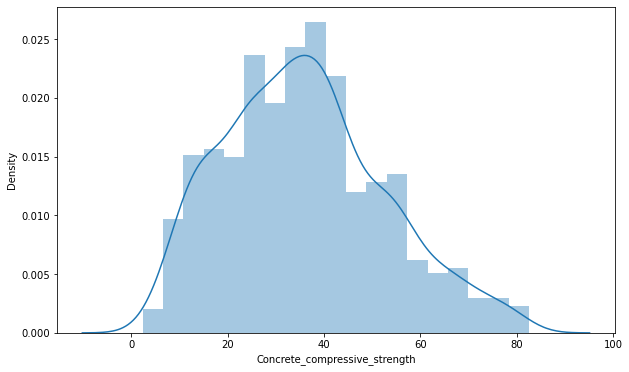

In [8]:
# check the distribution of the outcome
sns.distplot(concrete_source['Concrete_compressive_strength'])

## Convert to numpy objects

We need to end up with numpy X and Y matrices to use as inputs to the keras workflow. There are a number of possible ways to do this. In this case, we have no categorical variables, so it is a bit easier. If there were categorical variables we could use  the `get_dummies()` function from Pandas, although you could also find many other ways to do this. 

In [9]:
# pd.get_dummies()
## create numpy arrays from the target and inputs
Y = concrete_source['Concrete_compressive_strength'].values
X = concrete_source.drop('Concrete_compressive_strength',axis=1).values
Y
X

array([79.98611076, 61.88736576, 40.26953526, ..., 23.69660064,
       32.76803638, 32.40123514])

array([[ 540. ,    0. ,    0. , ..., 1040. ,  676. ,   28. ],
       [ 540. ,    0. ,    0. , ..., 1055. ,  676. ,   28. ],
       [ 332.5,  142.5,    0. , ...,  932. ,  594. ,  270. ],
       ...,
       [ 148.5,  139.4,  108.6, ...,  892.4,  780. ,   28. ],
       [ 159.1,  186.7,    0. , ...,  989.6,  788.9,   28. ],
       [ 260.9,  100.5,   78.3, ...,  864.5,  761.5,   28. ]])

## Setting up a training/validation/testing dataset

Recall our goal in machine learning in general - to develop an algorithm that minimizes **generalization error**.

However, we can't directly observe **generalization error**, since it is based on out of sample data. 

We need to set up a separate training and testing dataset for our models. We will use the training dataset to train model parameters, then use the the testing dataset to estimate generalization error (instead of training error). I will use a random subset of the data in this case.

> Other options can include leveraging time series elements of our data (if present), or leveraging clusters in our data (like stores, or plants, or customers). However we don't have those elements in this dataset, so we will use a random subset. 

In [10]:
from sklearn.model_selection import train_test_split
# initial split - default is to shuffle data and randomly split
X_train, X_test = train_test_split(X, train_size=0.8, random_state=4)
Y_train, Y_test = train_test_split(Y, train_size=0.8, random_state=4)
# check dims
print('training data size:', X_train.shape, Y_train.shape)
print('testing data size:', X_test.shape, Y_test.shape)

training data size: (824, 8) (824,)
testing data size: (206, 8) (206,)


## Build the first keras model

We will start with the equivalent model to a linear regression. The recommended default optimizer to use is `rmsprop`, so we will start there. 

> Notice that I am using the tensorflow.keras module instead of just keras. These are slightly different - tensorflow had imported the keras API into their library. There are minor differences, so this is important to note!

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# build a simple linear model


def build_model1():
    model = Sequential()
    model.add(Dense(1,
                    activation='linear',
                    input_dim=X_train.shape[1]))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

We will need to scale the training and testing data in a consistent manner. Let's use the sklearn `StandardScaler()` to accomplish this. This will apply the same transformation (based on the initial `.fit()` call) to subsequent datasets. 

In [12]:
# scale data with a transformer so we can later apply the same transformation
from sklearn import preprocessing
trans_1 = \
    preprocessing.StandardScaler().fit(X_train)
X_train_s = trans_1.transform(X_train)

Now we can fit the model to the dataset and investigate the results.

In [13]:
# fit this model/architecture to my data
regr1 = build_model1()
regr1.fit(X_train_s,
          Y_train,
          epochs=40,
          validation_split=0.2)

Epoch 1/40
21/21 [==============================] - 1s 26ms/step - loss: 1582.5912 - mae: 36.0106 - val_loss: 1589.4449 - val_mae: 35.6591
Epoch 2/40
21/21 [==============================] - 0s 6ms/step - loss: 1580.0669 - mae: 35.9872 - val_loss: 1586.8727 - val_mae: 35.6356
Epoch 3/40
21/21 [==============================] - 0s 4ms/step - loss: 1577.8403 - mae: 35.9667 - val_loss: 1584.3125 - val_mae: 35.6127
Epoch 4/40
21/21 [==============================] - 0s 4ms/step - loss: 1575.6094 - mae: 35.9463 - val_loss: 1581.7644 - val_mae: 35.5897
Epoch 5/40
21/21 [==============================] - ETA: 0s - loss: 1370.4677 - mae: 33.547 - 0s 5ms/step - loss: 1573.3766 - mae: 35.9265 - val_loss: 1579.2830 - val_mae: 35.5673
Epoch 6/40
21/21 [==============================] - 0s 11ms/step - loss: 1571.1432 - mae: 35.9059 - val_loss: 1576.7456 - val_mae: 35.5446
Epoch 7/40
21/21 [==============================] - 0s 10ms/step - loss: 1568.8696 - mae: 35.8845 - val_loss: 1574.0532 - val_ma

We can investigate the model object by asking for the layer weights (just the slope and one weight per input in this model) by asking for the model summary. 

In [14]:
# summarize model
regr1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Retrieve the weights
regr1.get_weights()

[array([[-0.18837717],
        [ 0.37555292],
        [-0.7539102 ],
        [ 0.10105105],
        [-0.03801519],
        [-0.10107158],
        [-1.0070562 ],
        [ 0.73229074]], dtype=float32),
 array([0.84617406], dtype=float32)]

Note these weights are the equivalent betas from a linear regression! 

A good way to understand if the model has fit is to monitor the training error and the validation error for both the loss function (MSE in this case), and another sensible metric (MAE). 

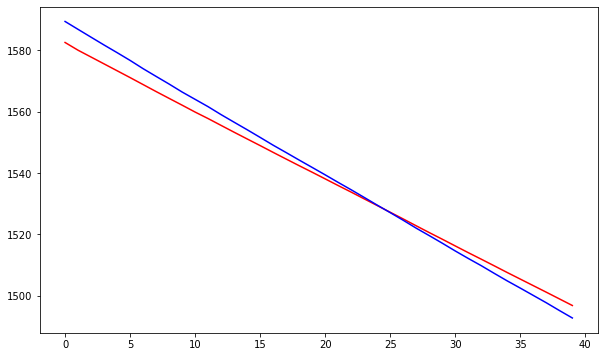

In [16]:
## plot the loss function per epoch
plt.plot(regr1.history.history['loss'],
        color='red')
plt.plot(regr1.history.history['val_loss'],
        color='blue')

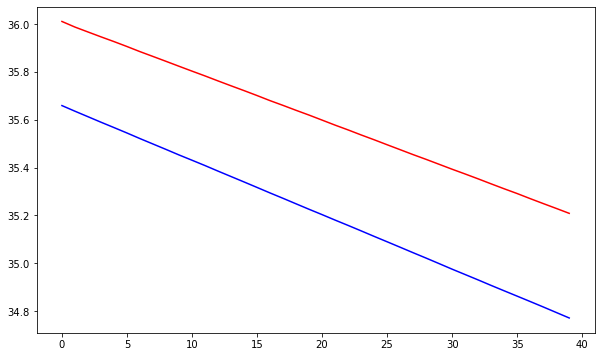

In [17]:
## plot the loss function per epoch
plt.plot(regr1.history.history['mae'],
         color='red')
plt.plot(regr1.history.history['val_mae'],
         color='blue')

It looks like the model is making progress, but we clearly need to run it for more epochs to get 'convergence'. I have turned the verbose flag to 0 here so we don't get as much output.  Let's do that..

In [18]:
# fit this model/architecture to my data
regr1 = build_model1()
regr1.fit(X_train_s,
          Y_train,
          epochs=2000,
          validation_split=0.2,
          verbose=0)

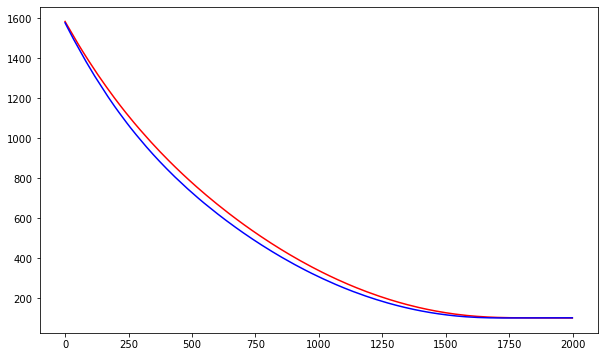

In [19]:
# plot the loss function per epoch
plt.plot(regr1.history.history['loss'],
         color='red')
plt.plot(regr1.history.history['val_loss'],
         color='blue')

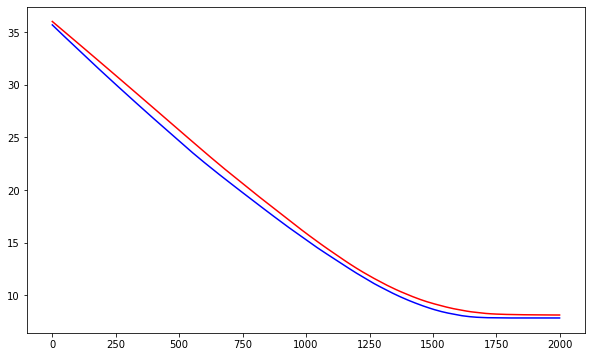

In [20]:
# plot the loss function per epoch
plt.plot(regr1.history.history['mae'],
         color='red')
plt.plot(regr1.history.history['val_mae'],
         color='blue')

It looks like the model converged by the 1700 epoch or so...let's look at those numbers:

In [21]:
# print metrics from the 15th epoch
regr1.history.history['val_loss'][1700:1725]
regr1.history.history['val_loss'][1975:2000]

regr1.history.history['val_mae'][1700:1725]
regr1.history.history['val_mae'][1975:2000]

[102.55960083007812,
 102.5516357421875,
 102.53875732421875,
 102.5284423828125,
 102.51785278320312,
 102.5083236694336,
 102.50236511230469,
 102.49250793457031,
 102.4820785522461,
 102.47599792480469,
 102.47016143798828,
 102.46369934082031,
 102.45072174072266,
 102.4444580078125,
 102.43926239013672,
 102.42831420898438,
 102.42305755615234,
 102.41697692871094,
 102.41114044189453,
 102.40404510498047,
 102.4007797241211,
 102.39459991455078,
 102.38863372802734,
 102.38379669189453,
 102.38192749023438]

[103.08821868896484,
 103.08817291259766,
 103.0886459350586,
 103.08966827392578,
 103.08911895751953,
 103.08745574951172,
 103.0881118774414,
 103.08675384521484,
 103.08454895019531,
 103.08956909179688,
 103.0893325805664,
 103.09033966064453,
 103.0937271118164,
 103.09260559082031,
 103.08889770507812,
 103.08866882324219,
 103.0913314819336,
 103.08889770507812,
 103.08675384521484,
 103.08787536621094,
 103.08915710449219,
 103.0925521850586,
 103.09398651123047,
 103.09370422363281,
 103.09790802001953]

[7.879232406616211,
 7.8785200119018555,
 7.877292633056641,
 7.876489162445068,
 7.875767707824707,
 7.875120639801025,
 7.874978542327881,
 7.874252796173096,
 7.873615741729736,
 7.873186111450195,
 7.872903347015381,
 7.872568130493164,
 7.871474742889404,
 7.87094783782959,
 7.870456218719482,
 7.869755268096924,
 7.869375705718994,
 7.868821144104004,
 7.868298053741455,
 7.867905139923096,
 7.867513656616211,
 7.867069244384766,
 7.866267204284668,
 7.865499019622803,
 7.865289211273193]

[7.84447717666626,
 7.844428539276123,
 7.844337463378906,
 7.844158172607422,
 7.844114780426025,
 7.843950271606445,
 7.8442158699035645,
 7.8443145751953125,
 7.844230651855469,
 7.844367980957031,
 7.844292163848877,
 7.8443498611450195,
 7.8443989753723145,
 7.844430446624756,
 7.844165802001953,
 7.843980312347412,
 7.8442301750183105,
 7.843832015991211,
 7.8437275886535645,
 7.843859672546387,
 7.843919277191162,
 7.844061374664307,
 7.844052791595459,
 7.8440423011779785,
 7.844231605529785]

Actually it looks like the validation error started getting a little bit worse towards the end! This could be a symptom of overfitting, although the current model does not have much capacity (just a linear model). 

We could find the minimum validation loss:

In [22]:
print('The min validation loss of',
      np.min(regr1.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr1.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr1.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr1.history.history['val_mae']))


The min validation loss of 102.34619140625 ,
 was at epoch 1735
The min validation mae of 7.8437275886535645 ,
 was at epoch 1993


That is a bit inconclusive....we are probably OK with regard to overfitting here. Let's investigate fitting a more flexible model...

## Build a more complex model

We can add complexity to our model by increasing the **depth** (adding hidden layers), and also increasing the **width** (adding more neurons per layer). 

In [23]:
# build a 2 layer neural network
def build_model2():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    input_dim=X_train.shape[1]))
    model.add(Dense(64,
                    activation='relu'))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [24]:
# fit this model/architecture to my data
regr2 = build_model2()
regr2.fit(X_train_s,
          Y_train,
          epochs=400,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [25]:
# summarize model
regr2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Retrieve the weights
# regr2.get_weights()
# This prints all the weights (4,000 +)

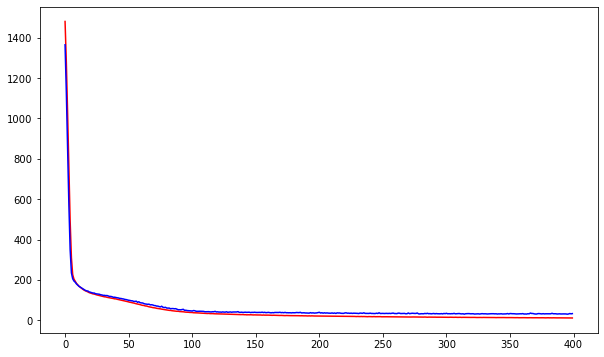

In [27]:
# plot the loss function per epoch
plt.plot(regr2.history.history['loss'],
         color='red')
plt.plot(regr2.history.history['val_loss'],
         color='blue')

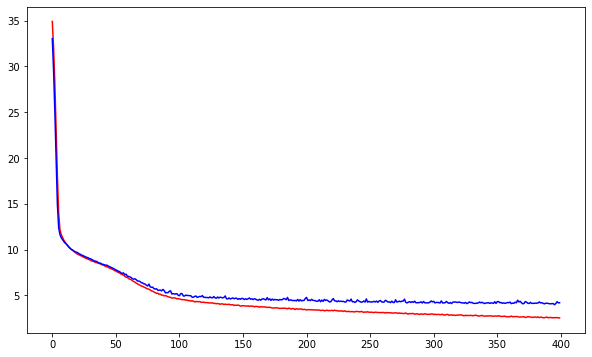

In [28]:
# plot the loss function per epoch
plt.plot(regr2.history.history['mae'],
         color='red')
plt.plot(regr2.history.history['val_mae'],
         color='blue')

This convergence pattern looks pretty good! How well did we do regarding error prediction? 

In [29]:
print('The min validation loss of',
      np.min(regr2.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr2.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_mae']))

The min validation loss of 30.100086212158203 ,
 was at epoch 395
The min validation mae of 3.9921622276306152 ,
 was at epoch 395


This implies we could run this for a bit longer since we have not yet overfit the data. Let's try more Epochs and look at the convergence again:

In [30]:
# fit this model/architecture to my data
regr2 = build_model2()
regr2.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.3,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [31]:
# summarize model
regr2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Retrieve the weights
# regr2.get_weights()
# This prints all the weights (4,000 +)

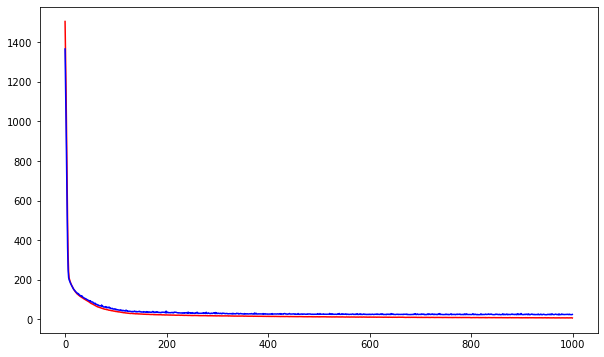

In [33]:
# plot the loss function per epoch
plt.plot(regr2.history.history['loss'],
         color='red')
plt.plot(regr2.history.history['val_loss'],
         color='blue')

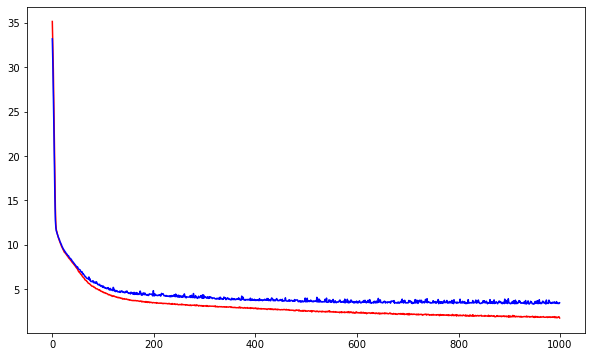

In [34]:
# plot the loss function per epoch
plt.plot(regr2.history.history['mae'],
         color='red')
plt.plot(regr2.history.history['val_mae'],
         color='blue')

This convergence pattern still looks pretty good! How well did we do regarding error prediction? 

In [35]:
print('The min validation loss of',
      np.min(regr2.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr2.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_mae']))

The min validation loss of 22.031641006469727 ,
 was at epoch 972
The min validation mae of 3.3454103469848633 ,
 was at epoch 939


This makes me think we have reached convergence by 1000 epochs, but we did need at least ~800 to get there. 

## Build a more complex model with dropout

It is possible we could get a better model fit on the validation dataset if we introduce some form of regularization. 

> A good general definition for Regularization is any modifications we make intending to increase generalization error at the expense of training error. 

One form of regularization is model dropout. This is easily implemented in keras:

In [36]:
# build a two layer neural network with regularization
from tensorflow.keras.layers import Dropout
def build_model3():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [37]:
# fit this model/architecture to my data
regr3 = build_model3()
regr3.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [38]:
## summarize model
regr3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

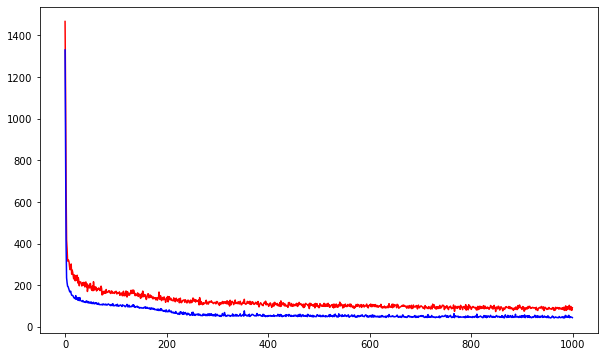

In [39]:
## plot the loss function per epoch
plt.plot(regr3.history.history['loss'],
        color='red')
plt.plot(regr3.history.history['val_loss'],
        color='blue')

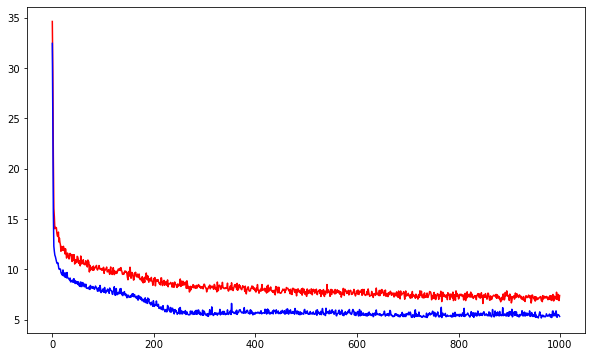

In [40]:
## plot the loss function per epoch
plt.plot(regr3.history.history['mae'],
         color='red')
plt.plot(regr3.history.history['val_mae'],
         color='blue')

In [41]:
print('The min validation loss of',
      np.min(regr3.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr3.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr3.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr3.history.history['val_mae']))

The min validation loss of 42.969417572021484 ,
 was at epoch 963
The min validation mae of 5.16500997543335 ,
 was at epoch 963


This is looking good. The model seemed to have converged by the 700 epoch or so, overfit does not seem to be an issue. We are at a bit higher error validation error than we were in the prior models though.  

## Build a more complex model with dropout, add L1 regularization

Another form of regularization we can apply is through applying penalties to the weights. This is exactly like what you have learned before in the context of penalized linear models (LASSO, Ridge, Elastic net...)

We can apply either L1, L2, or both penalties. 

-  Typically we penalize the weights but not the bias terms of the affine transformation for each neuron. 
-  We will typically use the same weight across the network, although we could consider optimizing a different weight for each neuron with input(s).
    -  This would be expensive (large hyper-parameter space to search). 
-  L2 penalty
    -  Like ridge regression. Reduces correlated inputs, but leaves weights in the model as small values. 
-  L1 penalty
    -  Like LASSO regression. Eliminates some weights, induces sparsity. 



Some notes on the keras syntax:

-  kernel_regularizer:
    -  This will regularize the weights matrix (the Beta’s)
-  activity_regularizer:
    -  This will regularize the output of the neuron (the activation function output)

-  bias_regularizer:
    -  This will regularize the bias term for the neuron

In [42]:
from tensorflow.keras.regularizers import l1
l1_penalty = 0.1
# build a two layer neural network with regularization


def build_model4():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [43]:
# fit this model/architecture to my data
regr4 = build_model4()
regr4.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [44]:
# summarize model
regr4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

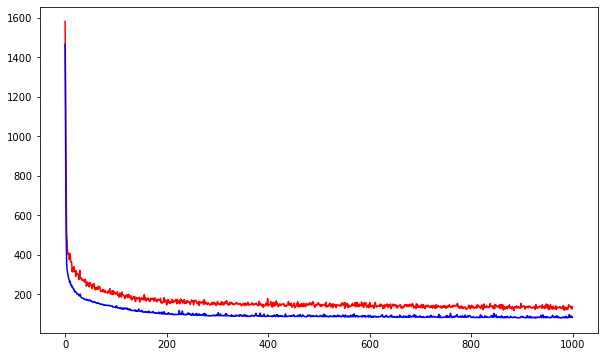

In [45]:
# plot the loss function per epoch
plt.plot(regr4.history.history['loss'],
         color='red')
plt.plot(regr4.history.history['val_loss'],
         color='blue')

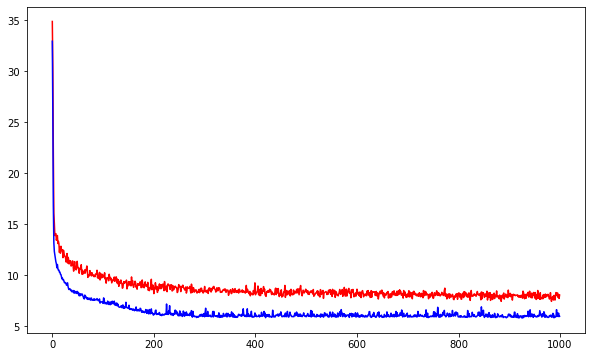

In [46]:
# plot the loss function per epoch
plt.plot(regr4.history.history['mae'],
         color='red')
plt.plot(regr4.history.history['val_mae'],
         color='blue')

In [47]:
print('The min validation loss of',
      np.min(regr4.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr4.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr4.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr4.history.history['val_mae']))

The min validation loss of 78.30735778808594 ,
 was at epoch 976
The min validation mae of 5.833879470825195 ,
 was at epoch 919


The model convergence looked good again, but the validation metrics are not better than without regularization. Perhaps we need a different strength penalty (different l1)?

## Build a more complex model with dropout, add L1 regularization, smaller weight. 

In [48]:
l1_penalty = 0.001
# build a two layer neural network with regularization


def build_model5():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [49]:
# fit this model/architecture to my data
regr5 = build_model5()
regr5.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [50]:
# summarize model
regr5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

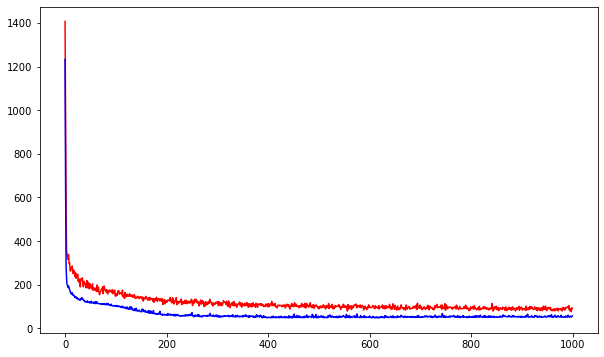

In [51]:
# plot the loss function per epoch
plt.plot(regr5.history.history['loss'],
         color='red')
plt.plot(regr5.history.history['val_loss'],
         color='blue')

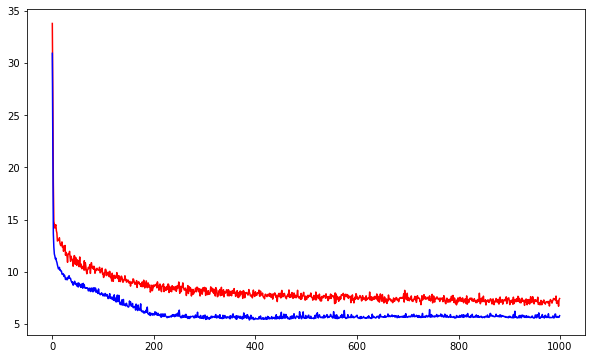

In [52]:
# plot the loss function per epoch
plt.plot(regr5.history.history['mae'],
         color='red')
plt.plot(regr5.history.history['val_mae'],
         color='blue')

In [53]:
print('The min validation loss of',
      np.min(regr5.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr5.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr5.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr5.history.history['val_mae']))

The min validation loss of 47.884037017822266 ,
 was at epoch 447
The min validation mae of 5.3811187744140625 ,
 was at epoch 388


The penalty gave us a similar result here. Sometimes (although not on this dataset), regularization will be necessary to avoid overfitting the dataset.

Let's compare all of the models we have fit thus far to get an idea of the best model (best on the validation data).

In [54]:
# comparison of mse (loss) on validation data
regr1.history.history['val_loss'][-1]
regr2.history.history['val_loss'][-1]
regr3.history.history['val_loss'][-1]
regr4.history.history['val_loss'][-1]
regr5.history.history['val_loss'][-1]

103.09790802001953

23.992101669311523

44.49125289916992

81.95675659179688

57.650550842285156

In [55]:
# comparison of mae on validation data
regr1.history.history['val_mae'][-1]
regr2.history.history['val_mae'][-1]
regr3.history.history['val_mae'][-1]
regr4.history.history['val_mae'][-1]
regr5.history.history['val_mae'][-1]

7.844231605529785

3.4856879711151123

5.31400203704834

6.005558013916016

5.792684078216553

It looks like our second model was the best model by either the loss function (mse) or the other chosen metric (mae). 

Let's select it as the 'best model', and score it on the test data. 

In [56]:
# What happened?!?
regr2.evaluate(x=X_test,y=Y_test)

7/7 [==============================] - 0s 584us/step - loss: 327463104.0000 - mae: 17940.2480


[327463104.0, 17940.248046875]

We need to transform the X as we did (standardize it). Good thing we set up the transformer!

In [57]:
# we need to transform the X...
regr2.evaluate(x=trans_1.transform(X_test),
               y=Y_test)

7/7 [==============================] - 0s 723us/step - loss: 27.9922 - mae: 3.6709


[27.992197036743164, 3.670870780944824]

## Conclusion

In this module, we have covered a lot! 

-  We learned how to implement a regression feed-forward NN using keras. 
-  We monitored our training error and our estimate of the generalization error via a validation dataset. 
-  We investigated some forms of regularization
-  And then we finally chose the 'best' model. 